In [1]:
import torch
import os
import python_utils
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from utils import Logger
from matplotlib import image
from os import listdir
from numpy import asarray
    
def logo_data():
    images = []
    files = os.listdir("logos_resize_png/")
    for file_name in files:
        img_data = image.imread('logos_resize_png/' + file_name)
        images.append(img_data)
    return images
# Load data
data = logo_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [2]:
torch.cuda.is_available()

False

In [3]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 9600
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 8192),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(8192, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(128, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [4]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 128
        n_out = 9600
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.1)
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(512, 8192),
            nn.LeakyReLU(0.1)
        )
        
        self.out = nn.Sequential(
            nn.Linear(8192, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [5]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 128))
    return n

In [6]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [7]:
loss = nn.BCELoss()


In [8]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [9]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [10]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

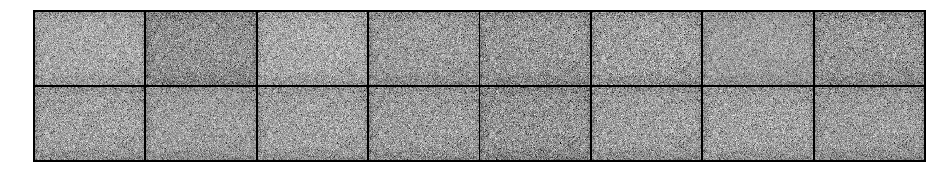

Epoch: [0/200], Batch Num: [0/160]
Discriminator Loss: 1.3861, Generator Loss: 0.7241
D(x): 0.4871, D(G(z)): 0.4866


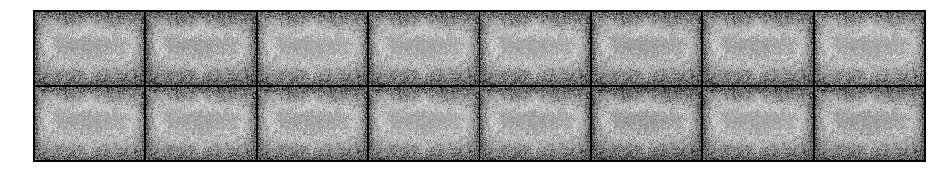

Epoch: [0/200], Batch Num: [100/160]
Discriminator Loss: 0.7650, Generator Loss: 5.6518
D(x): 0.5236, D(G(z)): 0.0140


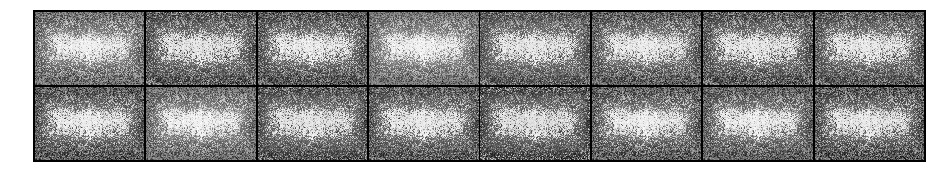

Epoch: [1/200], Batch Num: [0/160]
Discriminator Loss: 1.3418, Generator Loss: 3.7361
D(x): 0.8573, D(G(z)): 0.5592


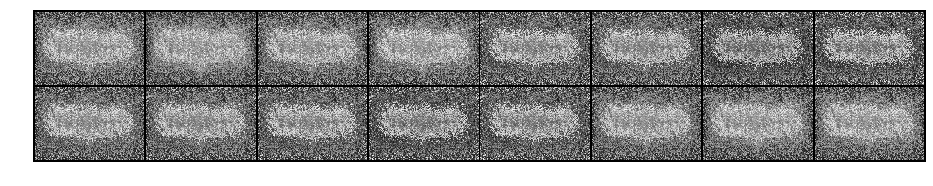

Epoch: [1/200], Batch Num: [100/160]
Discriminator Loss: 1.9973, Generator Loss: 16.3666
D(x): 0.2247, D(G(z)): 0.0813


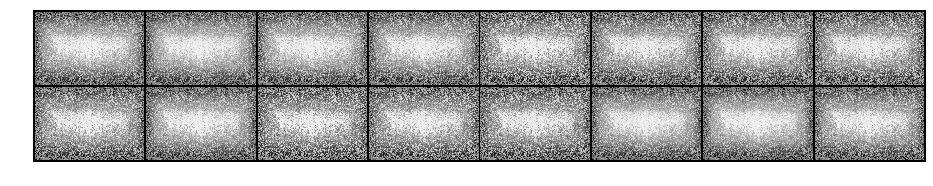

Epoch: [2/200], Batch Num: [0/160]
Discriminator Loss: 5.4207, Generator Loss: 0.2953
D(x): 0.2650, D(G(z)): 0.9354


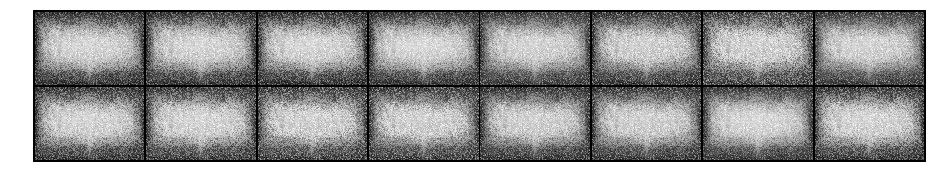

Epoch: [2/200], Batch Num: [100/160]
Discriminator Loss: 0.8736, Generator Loss: 4.0141
D(x): 0.5982, D(G(z)): 0.2034


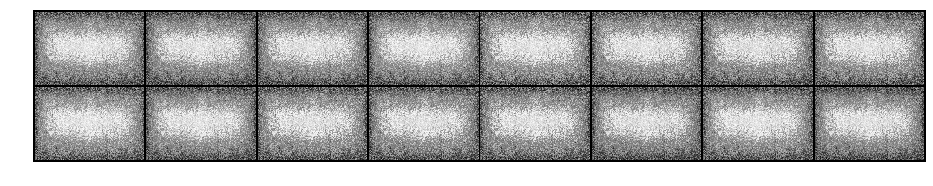

Epoch: [3/200], Batch Num: [0/160]
Discriminator Loss: 0.7070, Generator Loss: 4.9848
D(x): 0.5767, D(G(z)): 0.1035


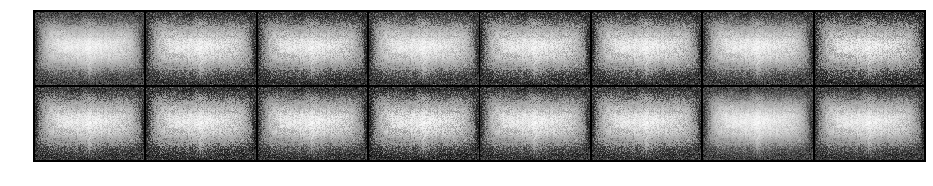

Epoch: [3/200], Batch Num: [100/160]
Discriminator Loss: 1.9340, Generator Loss: 1.2836
D(x): 0.2803, D(G(z)): 0.3441


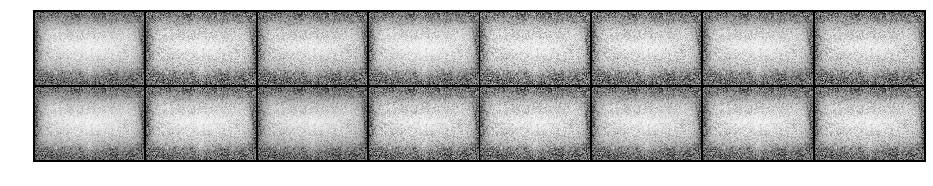

Epoch: [4/200], Batch Num: [0/160]
Discriminator Loss: 1.7948, Generator Loss: 1.8593
D(x): 0.4374, D(G(z)): 0.5211


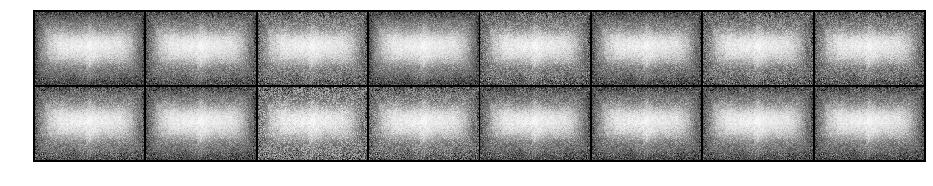

Epoch: [4/200], Batch Num: [100/160]
Discriminator Loss: 1.2922, Generator Loss: 1.8332
D(x): 0.4272, D(G(z)): 0.2485


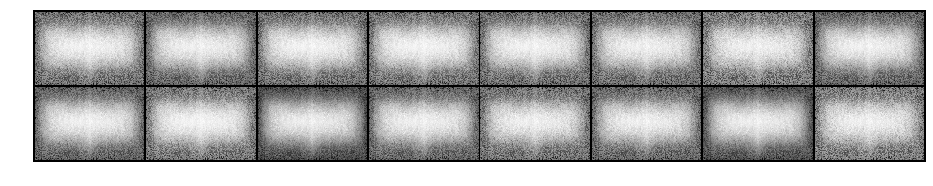

Epoch: [5/200], Batch Num: [0/160]
Discriminator Loss: 1.3409, Generator Loss: 5.8279
D(x): 0.4997, D(G(z)): 0.3224


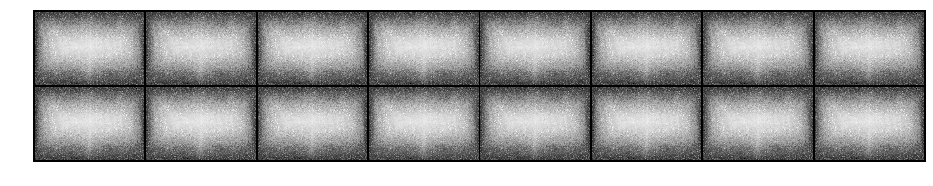

Epoch: [5/200], Batch Num: [100/160]
Discriminator Loss: 1.1353, Generator Loss: 2.1186
D(x): 0.4094, D(G(z)): 0.1756


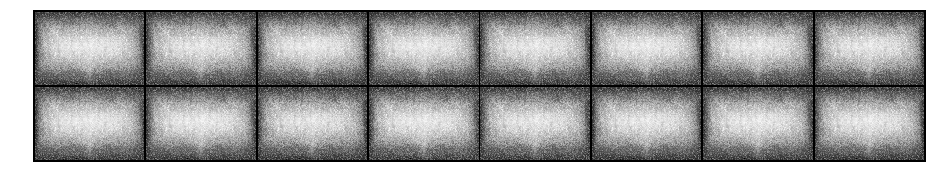

Epoch: [6/200], Batch Num: [0/160]
Discriminator Loss: 1.2187, Generator Loss: 3.1259
D(x): 0.4810, D(G(z)): 0.2920


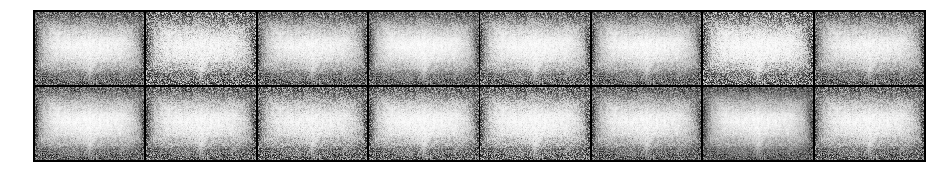

Epoch: [6/200], Batch Num: [100/160]
Discriminator Loss: 5.0579, Generator Loss: 2.8911
D(x): 0.1178, D(G(z)): 0.6544


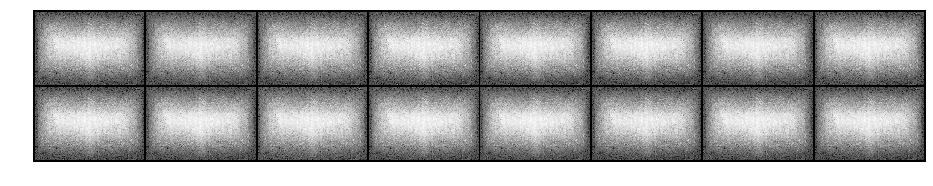

Epoch: [7/200], Batch Num: [0/160]
Discriminator Loss: 1.9041, Generator Loss: 6.6206
D(x): 0.6146, D(G(z)): 0.4552


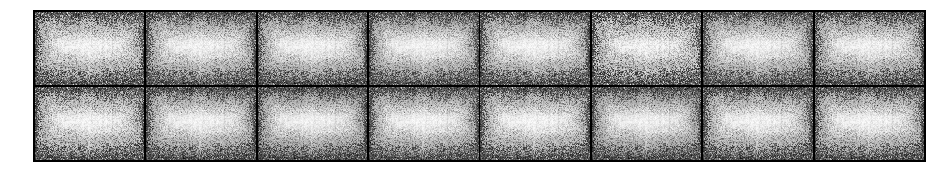

Epoch: [7/200], Batch Num: [100/160]
Discriminator Loss: 0.8028, Generator Loss: 3.9565
D(x): 0.5302, D(G(z)): 0.1260


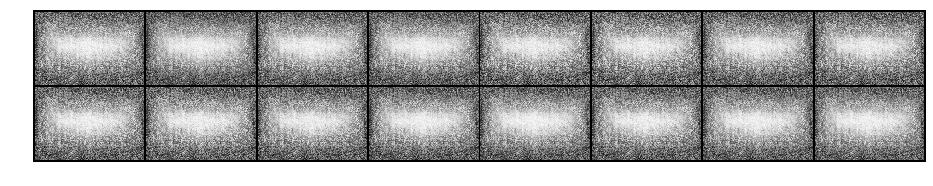

Epoch: [8/200], Batch Num: [0/160]
Discriminator Loss: 1.7345, Generator Loss: 0.4931
D(x): 0.6269, D(G(z)): 0.7002


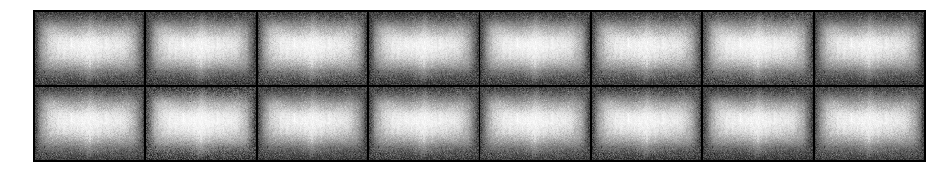

Epoch: [8/200], Batch Num: [100/160]
Discriminator Loss: 1.3507, Generator Loss: 2.6372
D(x): 0.5040, D(G(z)): 0.2951


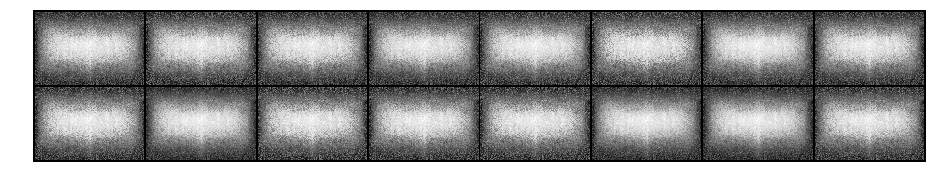

Epoch: [9/200], Batch Num: [0/160]
Discriminator Loss: 1.8658, Generator Loss: 0.4320
D(x): 0.5120, D(G(z)): 0.6673


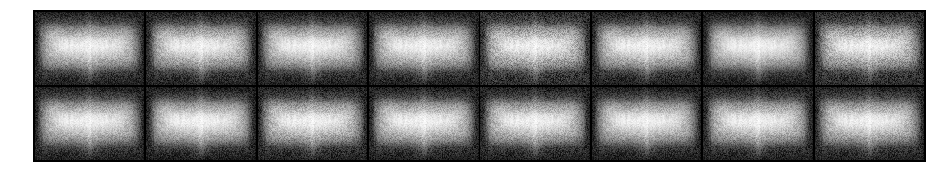

Epoch: [9/200], Batch Num: [100/160]
Discriminator Loss: 0.4428, Generator Loss: 8.0906
D(x): 0.8162, D(G(z)): 0.0678


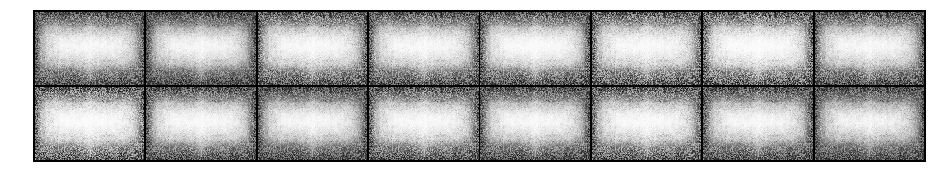

Epoch: [10/200], Batch Num: [0/160]
Discriminator Loss: 1.6883, Generator Loss: 3.2782
D(x): 0.3881, D(G(z)): 0.2522


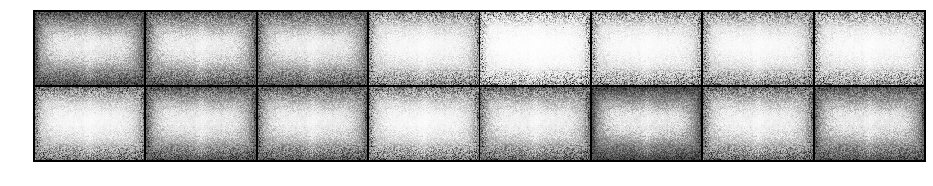

Epoch: [10/200], Batch Num: [100/160]
Discriminator Loss: 0.9750, Generator Loss: 1.6090
D(x): 0.5907, D(G(z)): 0.3225


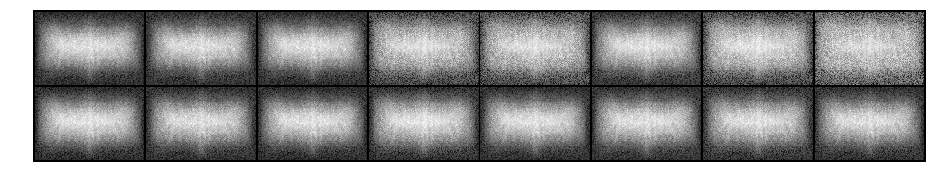

Epoch: [11/200], Batch Num: [0/160]
Discriminator Loss: 0.7812, Generator Loss: 2.3213
D(x): 0.6679, D(G(z)): 0.2401


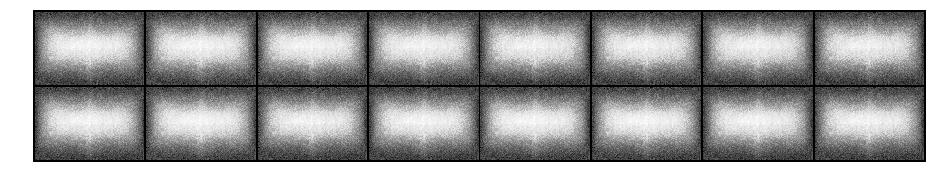

Epoch: [11/200], Batch Num: [100/160]
Discriminator Loss: 2.2102, Generator Loss: 1.0300
D(x): 0.3916, D(G(z)): 0.4940


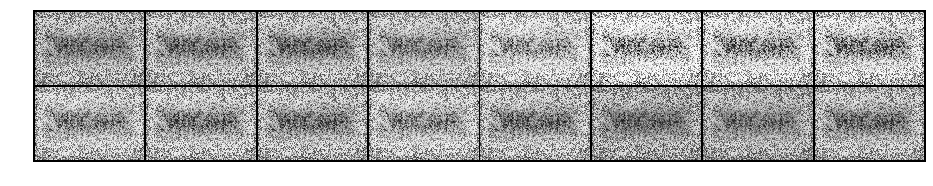

Epoch: [12/200], Batch Num: [0/160]
Discriminator Loss: 0.3250, Generator Loss: 5.0088
D(x): 0.8017, D(G(z)): 0.0581


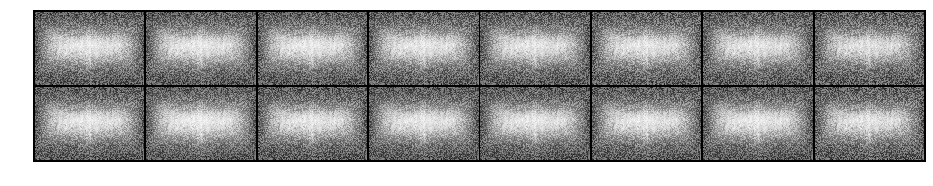

Epoch: [12/200], Batch Num: [100/160]
Discriminator Loss: 0.7041, Generator Loss: 1.1777
D(x): 0.8551, D(G(z)): 0.3821


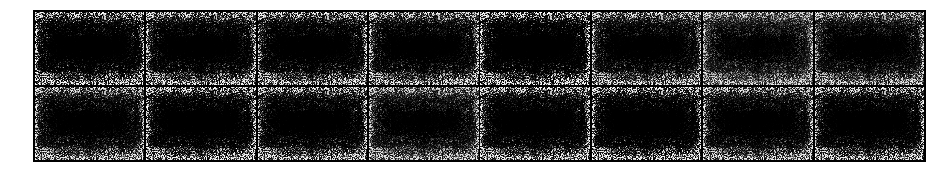

Epoch: [13/200], Batch Num: [0/160]
Discriminator Loss: 0.4084, Generator Loss: 27.6310
D(x): 0.9547, D(G(z)): 0.0000


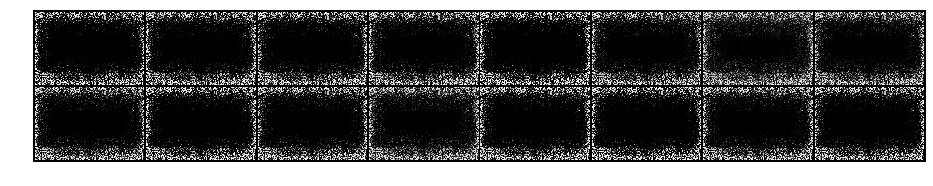

Epoch: [13/200], Batch Num: [100/160]
Discriminator Loss: 0.0003, Generator Loss: 27.6310
D(x): 0.9997, D(G(z)): 0.0000


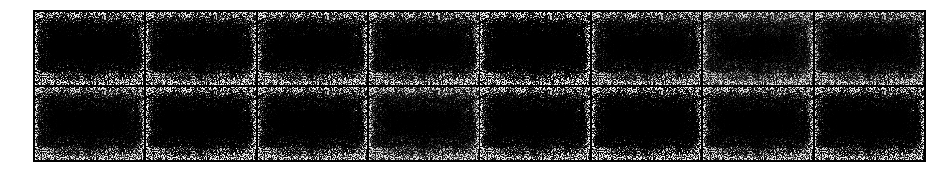

Epoch: [14/200], Batch Num: [0/160]
Discriminator Loss: 0.0000, Generator Loss: 27.6310
D(x): 1.0000, D(G(z)): 0.0000


KeyboardInterrupt: 

In [11]:
def images_to_vectors(images):
    return images.view(images.size(0), 9600)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 80, 120)

num_test_samples = 16
test_noise = noise(num_test_samples)

# Create logger instance
logger = Logger(model_name='VGAN', data_name='LOGOS')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch) in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
